In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import scipy
import os
from sklearn.linear_model import LinearRegression
import difflib
from matplotlib.colors import LinearSegmentedColormap, Normalize
from moviepy.editor import *
from IPython.display import display, HTML
sns.set_context(rc={'lines.linewidth': 2.5,
					'axes.labelsize': 25,
					'axes.titlesize': 19.200000000000003,
					'font.size': 25,
					'xtick.major.width': 8,
					'ytick.major.width': 8,
					'xtick.major.size':6,
					'ytick.major.size':6,
					'axes.linewidth':4})
display(HTML("<style>.container { width:85% !important; }</style>"))

Inits.

In [4]:
full_data = pd.read_pickle('fully_labeled_traces_feats3_071924.pickle')

# region and indexing-related variables / functions
region_ids = ['PrL (E)', 'PrL (I)', 'vLS (E)', 'vLS (I)', 'POA (E)', 'POA (I)',
	'BNST (E)', 'BNST (I)', 'AH (E)', 'AH (I)', 'MeA (E)', 'MeA (I)',
	'VMH (E)', 'VMH (I)', 'PAG (E)', 'PAG (I)', 'PMv (E)', 'PMv (I)', 'LHb (E)', 'LHb (I)', 
	'PA (E)', 'PA (I)', 'NAc (DA)'] # populations
indices = {val: idx for idx, val in enumerate(region_ids)} # dictionary with IDs for remapping
clusters = np.unique(full_data['91R2_d1_balbc_t1']['unsupervised labels'])
print(clusters)
agg_animals = ['3095', '3096', '3097', '4013', '4014', '4015', '4016', '91R2', '30L', '30B', '30R2', '29L']
obs_animals = ['30R2', '29L', '86L', '87L2', '927R', '927L', '933R']
non_animals = ['87R2', '87L', '87B', '86L2', '583L2', '583B']

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


### Computing and evaluating neural activity similarity between groups

In [5]:
animals = np.concatenate([agg_animals, obs_animals, non_animals])
all_activity = np.zeros((len(clusters), len(region_ids), 27, len(animals)))
all_activity[:] = np.nan

for a, animal in enumerate(animals):
	
	if a<=11:
		sessions = [x for x in list(full_data.keys()) if animal in x if '_balbc_' in x or '_mCD1_' in x]
	elif a<=18:
		sessions = [x for x in list(full_data.keys()) if animal in x if '_obs_' in x or '_OBSmCD1_' in x]
	else:
		sessions = [x for x in list(full_data.keys()) if animal in x if '_toy_' in x or '_toyCD1_' in x]
		
	for s, session in enumerate(sessions):
		
		sample = full_data[session]
		activity_per_cluster = np.zeros((len(clusters), all_activity.shape[1]))

		for i, c in enumerate(clusters):
			idxs2extract = np.where(sample['unsupervised labels'] == c)[0]
			for r, roi in enumerate(region_ids):
				if len(idxs2extract)==0:
					activity_per_cluster[i, r] = 0
				else:
					activity_per_cluster[i, r] = np.nanmean(sample[roi].iloc[idxs2extract])

		# Perform ranking
		all_activity[:, :, s, a] = activity_per_cluster
		

Compute distance statistics

In [43]:
from scipy.spatial import distance

def create_cluster_vectors(grid, n_clusters, n_animals=12):

	EI_grid = np.zeros((len(n_clusters), 23, grid.shape[2], n_animals))
	EI_grid[:] = np.nan

	for a in range(grid.shape[-1]):
		for i, idx in enumerate(np.arange(23)): # E indices
			roi = grid[n_clusters, idx, :, a] # if clusters are selected monotonically
			EI_grid[:, i, :, a] = roi

	return EI_grid

def vector_difference(vector1, vector2):
	"""
	Calculate the vector difference between two vectors.

	Parameters:
	- vector1: NumPy array or list, the first vector.
	- vector2: NumPy array or list, the second vector.

	Returns:
	- difference: Vector difference (vector1 - vector2).
	"""
	# Convert the input vectors to NumPy arrays
	vector1 = np.array(vector1)
	vector2 = np.array(vector2)

	# Calculate the vector difference
	difference = np.abs(vector1 - vector2)

	return np.sum(difference)

dist_func = vector_difference
n_clusters = np.arange(13) # for HF main fig
total_sessions = 27
n_rois = len(region_ids)

# ALL
n_animals = 25
activity_vectors = np.zeros((len(n_clusters), n_rois, 27, n_animals)) # modify the animals here
activity_vectors[:, :, :,:] = create_cluster_vectors(all_activity[:, :, :, :], n_clusters=np.array(n_clusters), n_animals=n_animals) 

# For saving
all_dists = np.zeros((total_sessions, n_rois, n_animals, n_animals))
all_dists[:] = np.nan
all_euclideans = all_dists.copy()
all_cosines = all_dists.copy()

for animal in np.arange(activity_vectors.shape[-1]):
	for roi in np.arange(n_rois):
		sample = activity_vectors[:, roi, :, animal]
		for second_animal in np.arange(activity_vectors.shape[-1]):
			if second_animal==animal:
				continue
			second_sample = activity_vectors[:, roi, :, second_animal]
			for session in np.arange(second_sample.shape[-1]):
				if np.all(np.isnan(second_sample[:, session])): # if all values are NaN,
					continue 
				all_euclideans[session, roi, animal, second_animal] = np.linalg.norm(sample[:, session] - second_sample[:, session])
				all_dists[session,roi,animal,second_animal] = dist_func(sample[:, session], second_sample[:, session])
				all_cosines[session,roi,animal,second_animal] = np.clip(distance.cosine(sample[:, session], second_sample[:, session]), -1,1)
		

Compute within-group distances and compare to across-group distances.

In [44]:
dist_vector = all_cosines.copy()

Hard fight distributions

VMH (E)
OBS vs. AGG = 84, OBS vs. NON = 42
PMv (E)
OBS vs. AGG = 63, OBS vs. NON = 42
AH (E)
OBS vs. AGG = 70, OBS vs. NON = 42
POA (E)
OBS vs. AGG = 84, OBS vs. NON = 42
MeA (E)
OBS vs. AGG = 77, OBS vs. NON = 42
PA (E)
OBS vs. AGG = 70, OBS vs. NON = 42
BNST (E)
OBS vs. AGG = 70, OBS vs. NON = 42
PAG (E)
OBS vs. AGG = 63, OBS vs. NON = 42
vLS (E)
OBS vs. AGG = 84, OBS vs. NON = 42
PrL (E)
OBS vs. AGG = 77, OBS vs. NON = 42
LHb (E)
OBS vs. AGG = 70, OBS vs. NON = 42
VMH (I)
OBS vs. AGG = 84, OBS vs. NON = 42
PMv (I)
OBS vs. AGG = 63, OBS vs. NON = 42
AH (I)
OBS vs. AGG = 70, OBS vs. NON = 42
POA (I)
OBS vs. AGG = 84, OBS vs. NON = 42
MeA (I)
OBS vs. AGG = 77, OBS vs. NON = 42
PA (I)
OBS vs. AGG = 70, OBS vs. NON = 42
BNST (I)
OBS vs. AGG = 70, OBS vs. NON = 42
PAG (I)
OBS vs. AGG = 63, OBS vs. NON = 42
vLS (I)
OBS vs. AGG = 84, OBS vs. NON = 42
PrL (I)
OBS vs. AGG = 77, OBS vs. NON = 42
LHb (I)
OBS vs. AGG = 70, OBS vs. NON = 42
NAc (DA)
OBS vs. AGG = 84, OBS vs. NON = 42


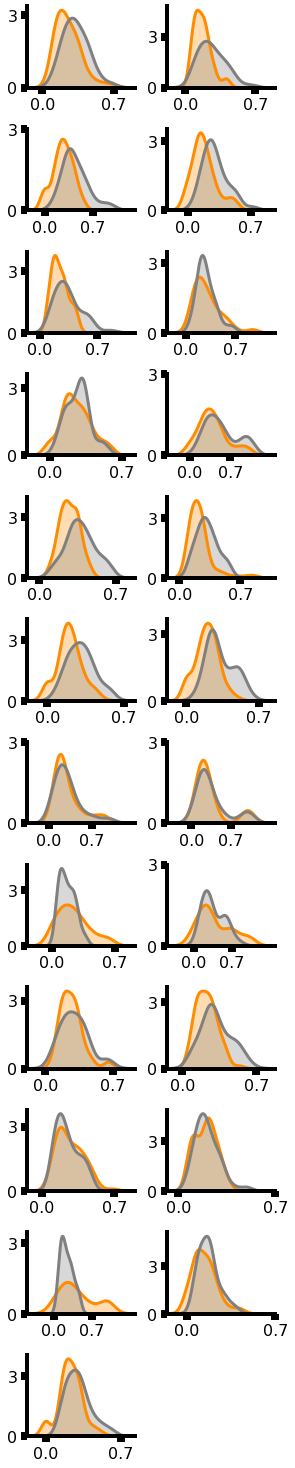

In [45]:
from scipy.stats import ks_2samp

# Assessing distributions during hard fight
t1 = -3
t2 = None
obs_non = np.median(dist_vector[t1:t2, :, np.arange(12, 19), 19:], axis=0)
obs_aggro = np.median(dist_vector[t1:t2, :, np.arange(12, 19), :12], axis=0)

# Inits
best_idxs = [12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19, 22]
indices_with_E = np.array([i for i, region in enumerate(region_ids) if "(E)" in region])
indices_with_I = np.array([i for i, region in enumerate(region_ids) if "(I)" in region])
indices_with_DA = np.array([i for i, region in enumerate(region_ids) if "DA" in region])
corrected_indices = np.concatenate([indices_with_E, indices_with_I, indices_with_DA])

# Figs
fig, ax = plt.subplots(12, 2, figsize=(4.2, 20.5))
# ax = ax.flatten()

p_values = []
ks_stats = []
for r, region in enumerate(best_idxs):

	distb1 = obs_aggro[region].flatten()
	distb1 = distb1[~np.isnan(distb1)]
	distb2 = obs_non[region].flatten()
	distb2 = distb2[~np.isnan(distb2)]
	print(region_ids[region])
	print('OBS vs. AGG = %i, OBS vs. NON = %i' % (len(distb1), len(distb2)))

	# Plot KDEs
	if r < 11:
		# ax[r, 0].set_title(region_ids[region].split(' ')[0], color='black')
		col = 0
	elif r < 22:
		col = 1
		r -= 11
	else:
		col = 0
		r -= 11
		
	sns.kdeplot(distb1, ax=ax[r, col], color='darkorange', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
	sns.kdeplot(distb1, ax=ax[r, col], color='darkorange', lw=3)  # Line with higher alpha
	sns.kdeplot(distb2, ax=ax[r, col], color='gray', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
	sns.kdeplot(distb2, ax=ax[r, col], color='gray', lw=3) 
	ax[r, col].set_ylabel('')
	ax[r, col].set_xticks([0, 0.7])
	ax[r, col].set_yticks([0, 3])
	ax[r, col].tick_params(axis='x', labelsize=16)
	ax[r, col].tick_params(axis='y', labelsize=16)
	
	sns.despine()

	ks_statistic, p_value = ks_2samp(distb1, distb2)
	p_values.append(p_value)
	ks_stats.append(ks_statistic)
# Remove empty axes
fig.delaxes(ax[11, 1])
plt.tight_layout()
# plt.savefig('.\\figures\\obs_non_aggro_distributions_HF_fixed.svg', dpi=300)

In [49]:
# run multiple comparisons correction

from statsmodels.stats.multitest import multipletests
reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_tsbh')
ks_stats = np.array(ks_stats)
pvals_uncorrected = np.array(p_values)
rows = []
for r, region in enumerate([region_ids[x] for x in best_idxs]):
	print('%s: KS = %f, p = %f' % (region, ks_stats[r], pvals_corrected[r]))
	# rows.append('KS = %f, p = %f' % (ks_stats[r], pvals_uncorrected[r]))
	rows.append('p = %f' % pvals_corrected[r])
df = pd.DataFrame(rows, columns=['Values'])
df.to_excel('data_list.xlsx', index=False)

VMH (E): KS = 0.285714, p = 0.017344
PMv (E): KS = 0.460317, p = 0.000136
AH (E): KS = 0.333333, p = 0.004945
POA (E): KS = 0.166667, p = 0.230593
MeA (E): KS = 0.406926, p = 0.000286
PA (E): KS = 0.400000, p = 0.000469
BNST (E): KS = 0.138095, p = 0.312766
PAG (E): KS = 0.253968, p = 0.057889
vLS (E): KS = 0.214286, p = 0.100377
PrL (E): KS = 0.145022, p = 0.281661
LHb (E): KS = 0.347619, p = 0.003213
VMH (I): KS = 0.404762, p = 0.000286
PMv (I): KS = 0.452381, p = 0.000136
AH (I): KS = 0.171429, p = 0.230593
POA (I): KS = 0.238095, p = 0.062093
MeA (I): KS = 0.445887, p = 0.000136
PA (I): KS = 0.438095, p = 0.000136
BNST (I): KS = 0.166667, p = 0.230593
PAG (I): KS = 0.198413, p = 0.162708
vLS (I): KS = 0.357143, p = 0.001815
PrL (I): KS = 0.151515, p = 0.265868
LHb (I): KS = 0.233333, p = 0.072938
NAc (DA): KS = 0.297619, p = 0.012683


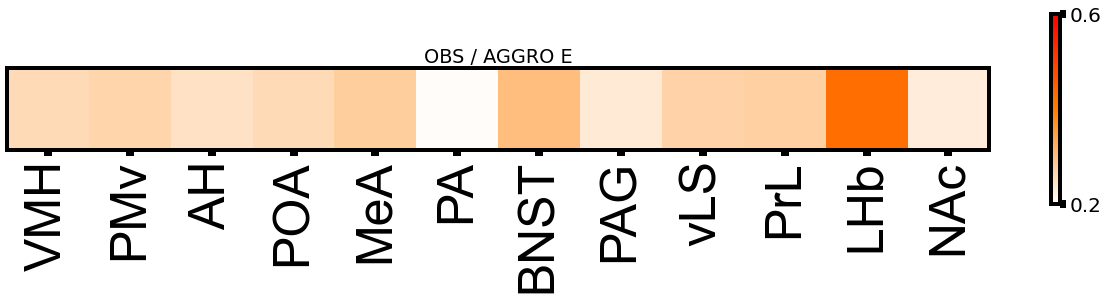

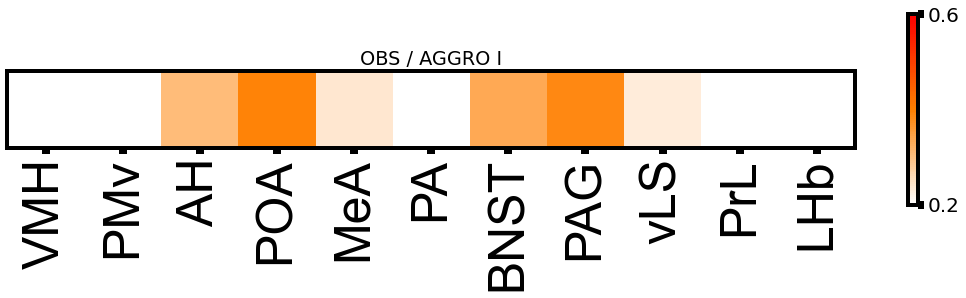

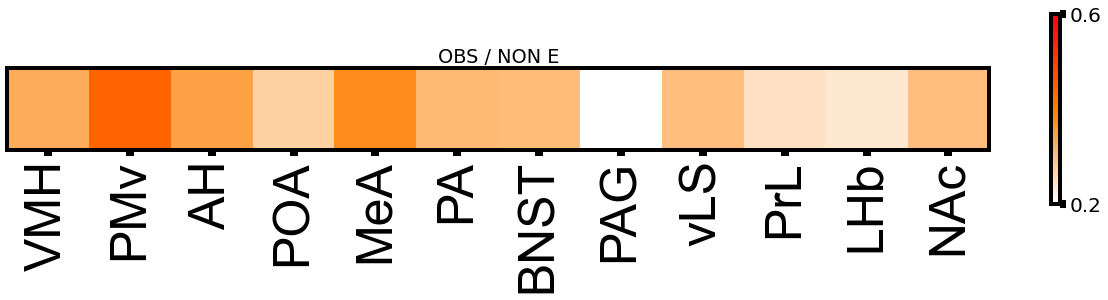

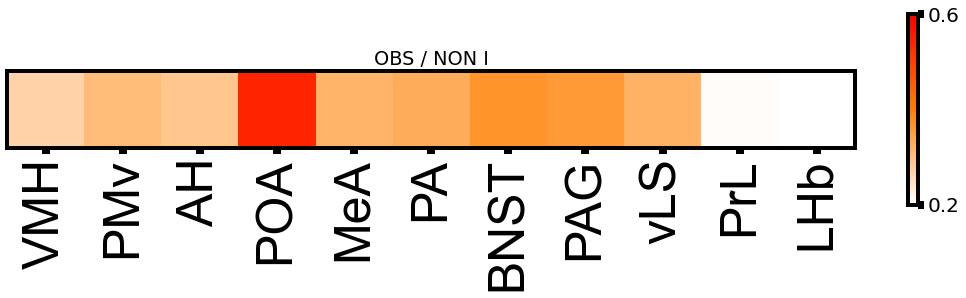

In [1101]:
np.set_printoptions(precision=4, suppress=True)
n = len(region_ids)
new_idx = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19, 22])
# define the colormap
colors = [(1, 1, 1), (1, 0.5, 0), (1, 0, 0)]  # White to orange to red
n_bins = 100  # Number of bins in the colormap
cmap_name = 'custom_autumn_r'
custom_cmap = LinearSegmentedColormap.from_list('some color', colors, N=n_bins)
cmap = custom_cmap.copy()

### OBS-AGG E 
new_idx = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 22])
weights2map = obs_aggro.copy()
weights2map = np.nanmean(weights2map, axis=-1)
weights = np.nanmean(weights2map, axis=1)
weights_sorted = weights[new_idx]
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for x in [region_ids[x] for x in new_idx]]
vmin=0.2
vmax = 0.6
norm = Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(22, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin, 12, vmax])
cbar.set_ticklabels([vmin, 12, vmax], fontsize=20)
ax.set_xticks(np.arange(len(new_idx)), all_labels, rotation=90, fontfamily='Arial', fontsize=50);
ax.set_yticks([])
ax.set_title('OBS / AGGRO E')
plt.savefig('.\\figures\\obs_aggro_distributions_means_E_HF.svg', dpi=300)

### OBS-AGG I
new_idx = np.array([13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19])
weights_sorted = weights[new_idx]
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for x in [region_ids[x] for x in new_idx]]
norm = Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(19, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin, 12, vmax])
cbar.set_ticklabels([vmin, 12, vmax], fontsize=20)
ax.set_xticks(np.arange(len(new_idx)), all_labels, rotation=90, fontfamily='Arial', fontsize=50);
ax.set_yticks([])
ax.set_title('OBS / AGGRO I')
plt.savefig('.\\figures\\obs_aggro_distributions_means_I_HF.svg', dpi=300)

### OBS-NON E 
new_idx = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 22])
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for x in [region_ids[x] for x in new_idx]]
weights2map = obs_non.copy()
weights2map = np.nanmean(weights2map, axis=-1)
weights = np.nanmean(weights2map, axis=-1)
weights_sorted = weights[new_idx]
fig, ax = plt.subplots(figsize=(22, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin, 12, vmax])
cbar.set_ticklabels([vmin, 12, vmax], fontsize=20)
ax.set_xticks(np.arange(len(new_idx)), all_labels, rotation=90, fontfamily='Arial', fontsize=50);
ax.set_yticks([])
ax.set_title('OBS / NON E')
plt.savefig('.\\figures\\obs_non_distributions_means_E_HF.svg', dpi=300)

### OBS-NON I
new_idx = np.array([13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19])
weights_sorted = weights[new_idx]
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for x in [region_ids[x] for x in new_idx]]
norm = Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(19, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin, 12, vmax])
cbar.set_ticklabels([vmin, 12, vmax], fontsize=20)
ax.set_xticks(np.arange(len(new_idx)), all_labels, rotation=90, fontfamily='Arial', fontsize=50);
ax.set_yticks([])
ax.set_title('OBS / NON I')
plt.savefig('.\\figures\\obs_non_distributions_means_I_HF.svg', dpi=300)


In [51]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

new_idx = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19, 22])
p_values = []  # List to collect all p-values
t_values = []
test_types = []

# Assuming your vectors are named vector1, vector2, and vector3
for r, roi in enumerate(region_ids):
	agg_roi_activity = obs_aggro[r, :][np.isnan(obs_aggro[r, :])==False]
	non_roi_activity = obs_non[r, :][np.isnan(obs_non[r, :])==False]

	# Test for normality
	_, p_agg = stats.shapiro(agg_roi_activity)
	_, p_non = stats.shapiro(non_roi_activity)

	# If the p-value is greater than 0.05, the data is normally distributed
	if p_agg > 0.05 and p_non > 0.05:
		# Perform t-tests
		t, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
		test_types.append('t')
	else:
		# Perform Wilcoxon rank-sum tests
		t, p_agg_non = stats.mannwhitneyu(agg_roi_activity, non_roi_activity)
		test_types.append('U')
	p_values.append(p_agg_non) 
	t_values.append(t)
	
# Apply FDR correction
p_values = np.asarray(p_values)[new_idx]
t_values = np.asarray(t_values)[new_idx]
test_types = np.asarray(test_types)[new_idx]
p_adjusted = multipletests(p_values, method='fdr_tsbh')[1]

# save stats
rows = []
for r, region in enumerate([region_ids[x] for x in new_idx]):
	print('%s: %s = %f, p = %f' % (region, test_types[r], t_values[r], p_adjusted[r]))
	# rows.append('%s = %f, p = %f' % (test_types[r], t_values[r], p_values[r]))
	rows.append('p = %f' % p_adjusted[r])
df = pd.DataFrame(rows, columns=['Values'])
df.to_excel('data_list.xlsx', index=False)

VMH (E): U = 1136.000000, p = 0.001289
PMv (E): U = 623.000000, p = 0.000012
AH (E): U = 934.000000, p = 0.001289
POA (E): U = 1621.000000, p = 0.242528
MeA (E): t = -5.013996, p = 0.000012
PA (E): t = -4.569104, p = 0.000026
BNST (E): U = 1407.000000, p = 0.353597
PAG (E): U = 1591.000000, p = 0.053416
vLS (E): U = 1522.000000, p = 0.132107
PrL (E): U = 1800.000000, p = 0.182463
LHb (E): U = 1963.000000, p = 0.002555
VMH (I): U = 972.000000, p = 0.000058
PMv (I): U = 624.000000, p = 0.000012
AH (I): U = 1425.000000, p = 0.358693
POA (I): U = 1219.000000, p = 0.003702
MeA (I): U = 883.000000, p = 0.000058
PA (I): U = 700.000000, p = 0.000012
BNST (I): U = 1326.000000, p = 0.215487
PAG (I): U = 1319.000000, p = 0.426840
vLS (I): t = -4.222145, p = 0.000058
PrL (I): U = 1562.000000, p = 0.358693
LHb (I): U = 1155.000000, p = 0.041933
NAc (DA): U = 1187.000000, p = 0.002555


(812,)
(462,)
(812,)
(462,)
KS test E: 8.841103436019182e-05
statistic = 0.1296462158531124
KS test I: 6.307621092105364e-12
statistic = 0.21062845200776234


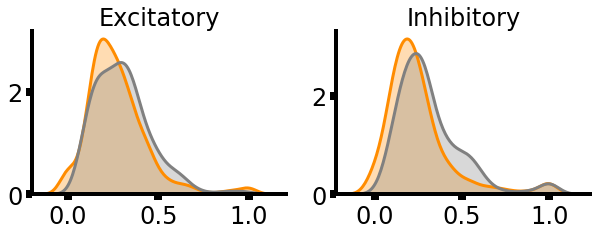

In [52]:
# define idxs
I_idxs = np.arange(1, 23, 2)
E_idxs = np.arange(0, 22, 2)

# extract e vs i similarities
E_obs_aggro = obs_aggro[E_idxs]
E_obs_non = obs_non[E_idxs]
I_obs_aggro = obs_aggro[I_idxs]
I_obs_non = obs_non[I_idxs]

distb1_E = E_obs_aggro.flatten()
distb1_E = distb1_E[~np.isnan(distb1_E)]
print(distb1_E.shape)
distb2_E = E_obs_non.flatten()
distb2_E = distb2_E[~np.isnan(distb2_E)]
print(distb2_E.shape)
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# plot exc distributions
sns.kdeplot(distb1_E, ax=ax[0], color='darkorange', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
sns.kdeplot(distb1_E, ax=ax[0], color='darkorange', lw=3)  # Line with higher alpha
sns.kdeplot(distb2_E, ax=ax[0], color='gray', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
sns.kdeplot(distb2_E, ax=ax[0], color='gray', lw=3) 
ax[0].set_ylabel('')
ax[0].tick_params(axis='y', labelsize=24)
ax[0].tick_params(axis='x', labelsize=24)
ax[0].set_title('Excitatory', fontsize=24)

# plot inhibitory distributions
distb1_I = I_obs_aggro.flatten()
distb1_I = distb1_I[~np.isnan(distb1_I)]
print(distb1_I.shape)
distb2_I = I_obs_non.flatten()
distb2_I = distb2_I[~np.isnan(distb2_I)]
print(distb2_I.shape)
sns.kdeplot(distb1_I, ax=ax[1], color='darkorange', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
sns.kdeplot(distb1_I, ax=ax[1], color='darkorange', lw=3)  # Line with higher alpha
sns.kdeplot(distb2_I, ax=ax[1], color='gray', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
sns.kdeplot(distb2_I, ax=ax[1], color='gray', lw=3)
ax[1].set_ylabel('')
ax[1].tick_params(axis='y', labelsize=24)
ax[1].tick_params(axis='x', labelsize=24)
ax[1].set_title('Inhibitory', fontsize=24)
sns.despine()

ks, p_value = ks_2samp(distb1_E, distb2_E)
print(f'KS test E: {p_value}')
print('statistic =', ks)
ks, p_value = ks_2samp(distb1_I, distb2_I)
print(f'KS test I: {p_value}')
print('statistic =', ks)
# p_values.append(p_value)
# plt.savefig('.\\figures\\E&I_HF.svg', dpi=300)



Training period distributions

In [22]:
n_clusters = np.arange(10) # for TP main fig
total_sessions = 27
n_rois = len(region_ids)

# ALL
n_animals = 25
activity_vectors = np.zeros((len(n_clusters), n_rois, 27, n_animals)) # modify the animals here
activity_vectors[:, :, :,:] = create_cluster_vectors(all_activity[:, :, :, :], n_clusters=np.array(n_clusters), n_animals=n_animals) 

# For saving
all_dists = np.zeros((total_sessions, n_rois, n_animals, n_animals))
all_dists[:] = np.nan
all_euclideans = all_dists.copy()
all_cosines = all_dists.copy()

for animal in np.arange(activity_vectors.shape[-1]):
	for roi in np.arange(n_rois):
		sample = activity_vectors[:, roi, :, animal]
		for second_animal in np.arange(activity_vectors.shape[-1]):
			if second_animal==animal:
				continue
			second_sample = activity_vectors[:, roi, :, second_animal]
			for session in np.arange(second_sample.shape[-1]):
				if np.all(np.isnan(second_sample[:, session])): # if all values are NaN,
					continue 
				all_euclideans[session, roi, animal, second_animal] = np.linalg.norm(sample[:, session] - second_sample[:, session])
				all_dists[session,roi,animal,second_animal] = dist_func(sample[:, session], second_sample[:, session])
				all_cosines[session,roi,animal,second_animal] = np.clip(distance.cosine(sample[:, session], second_sample[:, session]), -1,1)
		

In [23]:
dist_vector = all_cosines.copy()

VMH (E)
OBS vs. AGG = 84, OBS vs. NON = 42
PMv (E)
OBS vs. AGG = 56, OBS vs. NON = 42
AH (E)
OBS vs. AGG = 70, OBS vs. NON = 42
POA (E)
OBS vs. AGG = 77, OBS vs. NON = 42
MeA (E)
OBS vs. AGG = 77, OBS vs. NON = 42
PA (E)
OBS vs. AGG = 63, OBS vs. NON = 42
BNST (E)
OBS vs. AGG = 70, OBS vs. NON = 42
PAG (E)
OBS vs. AGG = 56, OBS vs. NON = 42
vLS (E)
OBS vs. AGG = 84, OBS vs. NON = 42
PrL (E)
OBS vs. AGG = 77, OBS vs. NON = 42
LHb (E)
OBS vs. AGG = 63, OBS vs. NON = 42
VMH (I)
OBS vs. AGG = 84, OBS vs. NON = 42
PMv (I)
OBS vs. AGG = 56, OBS vs. NON = 42
AH (I)
OBS vs. AGG = 70, OBS vs. NON = 42
POA (I)
OBS vs. AGG = 77, OBS vs. NON = 42
MeA (I)
OBS vs. AGG = 77, OBS vs. NON = 42
PA (I)
OBS vs. AGG = 63, OBS vs. NON = 42
BNST (I)
OBS vs. AGG = 70, OBS vs. NON = 42
PAG (I)
OBS vs. AGG = 56, OBS vs. NON = 42
vLS (I)
OBS vs. AGG = 84, OBS vs. NON = 42
PrL (I)
OBS vs. AGG = 77, OBS vs. NON = 42
LHb (I)
OBS vs. AGG = 63, OBS vs. NON = 42
NAc (DA)
OBS vs. AGG = 77, OBS vs. NON = 42


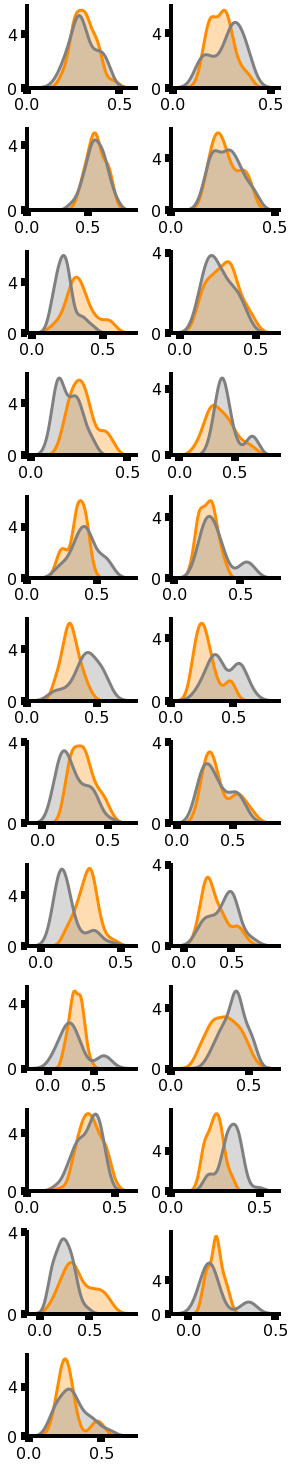

In [24]:
t1 = 0
t2 = -3
obs_non = np.mean(dist_vector[t1:t2, :, np.arange(12, 19), 19:], axis=0)
obs_aggro = np.mean(dist_vector[t1:t2, :, np.arange(12, 19), :12], axis=0)

# Inits
best_idxs = [12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19, 22]
indices_with_E = np.array([i for i, region in enumerate(region_ids) if "(E)" in region])
indices_with_I = np.array([i for i, region in enumerate(region_ids) if "(I)" in region])
indices_with_DA = np.array([i for i, region in enumerate(region_ids) if "DA" in region])
corrected_indices = np.concatenate([indices_with_E, indices_with_I, indices_with_DA])

# Figs
fig, ax = plt.subplots(12, 2, figsize=(4.2, 20.5))
# ax = ax.flatten()

p_values = []
ks_stats = []
for r, region in enumerate(best_idxs):

	distb1 = obs_aggro[region].flatten()
	distb1 = distb1[~np.isnan(distb1)]
	distb2 = obs_non[region].flatten()
	distb2 = distb2[~np.isnan(distb2)]
	print(region_ids[region])
	print('OBS vs. AGG = %i, OBS vs. NON = %i' % (len(distb1), len(distb2)))

	# Plot KDEs
	if r < 11:
		# ax[r, 0].set_title(region_ids[region].split(' ')[0], color='black')
		col = 0
	elif r < 22:
		col = 1
		r -= 11
	else:
		col = 0
		r -= 11
		
	sns.kdeplot(distb1, ax=ax[r, col], color='darkorange', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
	sns.kdeplot(distb1, ax=ax[r, col], color='darkorange', lw=3)  # Line with higher alpha
	sns.kdeplot(distb2, ax=ax[r, col], color='gray', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
	sns.kdeplot(distb2, ax=ax[r, col], color='gray', lw=3) 
	ax[r, col].set_ylabel('')
	ax[r, col].set_xticks([0, 0.5])
	ax[r, col].set_yticks([0, 4])
	ax[r, col].tick_params(axis='x', labelsize=16)
	ax[r, col].tick_params(axis='y', labelsize=16)
	
	sns.despine()

	ks_statistic, p_value = ks_2samp(distb1, distb2)
	p_values.append(p_value)
	ks_stats.append(ks_statistic)
# Remove empty axes
fig.delaxes(ax[11, 1])
plt.tight_layout()
# plt.savefig('.\\figures\\obs_non_aggro_distributions_TP_fixed.svg', dpi=300)

In [30]:
# run multiple comparisons correction

from statsmodels.stats.multitest import multipletests
reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_tsbh')
ks_stats = np.array(ks_stats)
pvals_uncorrected = np.array(p_values)
rows = []
for r, region in enumerate([region_ids[x] for x in best_idxs]):
	print('%s: KS = %f, p = %f' % (region, ks_stats[r], pvals_uncorrected[r]))
	# rows.append('KS = %f, p = %f' % (ks_stats[r], pvals_uncorrected[r]))
	rows.append('p = %f' % pvals_corrected[r])
df = pd.DataFrame(rows, columns=['Values'])
df.to_excel('data_list.xlsx', index=False)

VMH (E): KS = 0.142857, p = 0.603942
PMv (E): KS = 0.089286, p = 0.983038
AH (E): KS = 0.614286, p = 0.000000
POA (E): KS = 0.450216, p = 0.000017
MeA (E): KS = 0.361472, p = 0.001133
PA (E): KS = 0.603175, p = 0.000000
BNST (E): KS = 0.423810, p = 0.000099
PAG (E): KS = 0.696429, p = 0.000000
vLS (E): KS = 0.333333, p = 0.003441
PrL (E): KS = 0.147186, p = 0.544787
LHb (E): KS = 0.444444, p = 0.000059
VMH (I): KS = 0.333333, p = 0.003441
PMv (I): KS = 0.160714, p = 0.520871
AH (I): KS = 0.209524, p = 0.176207
POA (I): KS = 0.367965, p = 0.000863
MeA (I): KS = 0.246753, p = 0.060470
PA (I): KS = 0.539683, p = 0.000000
BNST (I): KS = 0.157143, p = 0.492952
PAG (I): KS = 0.398810, p = 0.000665
vLS (I): KS = 0.369048, p = 0.000796
PrL (I): KS = 0.681818, p = 0.000000
LHb (I): KS = 0.349206, p = 0.003378
NAc (DA): KS = 0.259740, p = 0.041682


Text(0.5, 1.0, 'OBS / NON I')

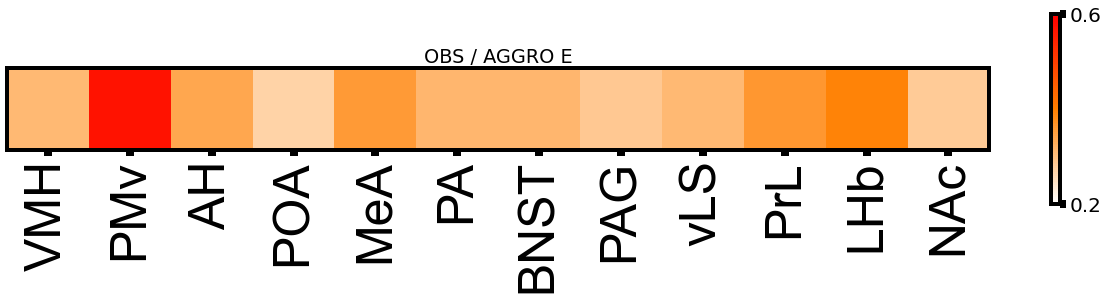

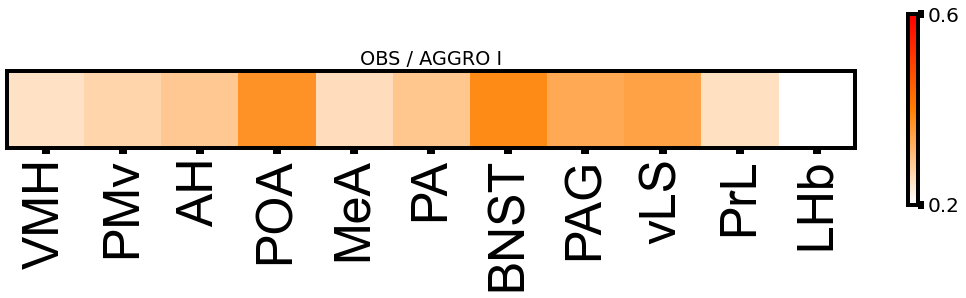

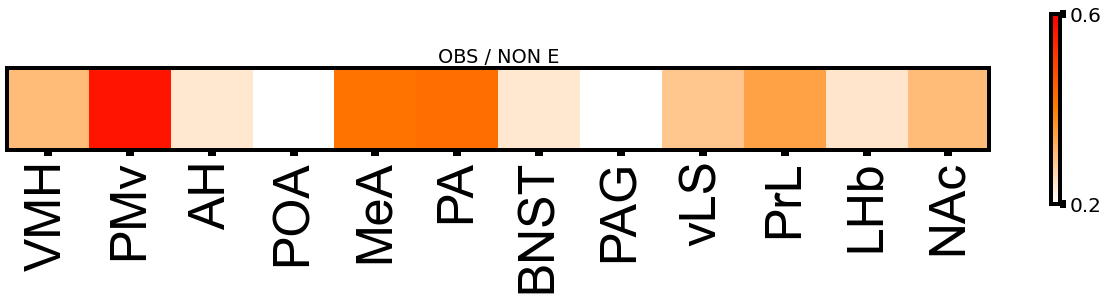

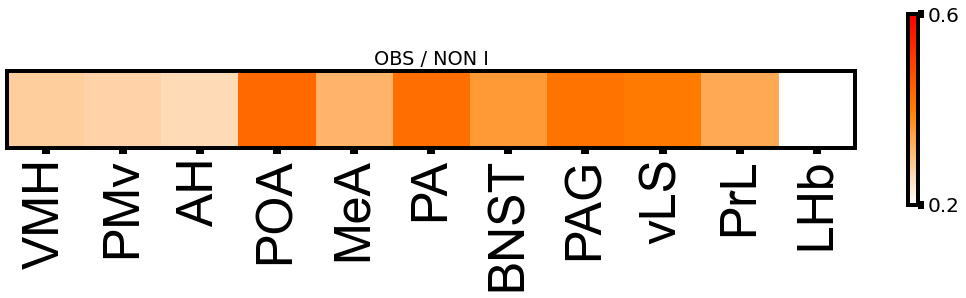

In [31]:
np.set_printoptions(precision=4, suppress=True)
n = len(region_ids)
new_idx = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19, 22])
# define the colormap
colors = [(1, 1, 1), (1, 0.5, 0), (1, 0, 0)]  # White to orange to red
n_bins = 100  # Number of bins in the colormap
cmap_name = 'custom_autumn_r'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
cmap = custom_cmap.copy()

### OBS-AGG E 
new_idx = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 22])
weights2map = obs_aggro.copy()
weights2map = np.nanmean(weights2map, axis=-1)
weights = np.nanmean(weights2map, axis=1)
weights_sorted = weights[new_idx]
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for x in [region_ids[x] for x in new_idx]]
vmin=0.2
vmax = 0.6
norm = Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(22, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin, 12, vmax])
cbar.set_ticklabels([vmin, 12, vmax], fontsize=20)
ax.set_xticks(np.arange(len(new_idx)), all_labels, rotation=90, fontfamily='Arial', fontsize=50);
ax.set_yticks([])
ax.set_title('OBS / AGGRO E')
# plt.savefig('.\\figures\\obs_aggro_distributions_means_E_TP.svg', dpi=300)

### OBS-AGG I
new_idx = np.array([13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19])
weights_sorted = weights[new_idx]
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for x in [region_ids[x] for x in new_idx]]
norm = Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(19, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin, 12, vmax])
cbar.set_ticklabels([vmin, 12, vmax], fontsize=20)
ax.set_xticks(np.arange(len(new_idx)), all_labels, rotation=90, fontfamily='Arial', fontsize=50);
ax.set_yticks([])
ax.set_title('OBS / AGGRO I')
# plt.savefig('.\\figures\\obs_aggro_distributions_means_I_TP.svg', dpi=300)

### OBS-NON E 
new_idx = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 22])
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for x in [region_ids[x] for x in new_idx]]
weights2map = obs_non.copy()
weights2map = np.nanmean(weights2map, axis=-1)
weights = np.nanmean(weights2map, axis=-1)
weights_sorted = weights[new_idx]
fig, ax = plt.subplots(figsize=(22, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin, 12, vmax])
cbar.set_ticklabels([vmin, 12, vmax], fontsize=20)
ax.set_xticks(np.arange(len(new_idx)), all_labels, rotation=90, fontfamily='Arial', fontsize=50);
ax.set_yticks([])
ax.set_title('OBS / NON E')
# plt.savefig('.\\figures\\obs_non_distributions_means_E_TP.svg', dpi=300)

### OBS-NON I
new_idx = np.array([13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19])
weights_sorted = weights[new_idx]
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for x in [region_ids[x] for x in new_idx]]
norm = Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(19, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin, 12, vmax])
cbar.set_ticklabels([vmin, 12, vmax], fontsize=20)
ax.set_xticks(np.arange(len(new_idx)), all_labels, rotation=90, fontfamily='Arial', fontsize=50);
ax.set_yticks([])
ax.set_title('OBS / NON I')
# plt.savefig('.\\figures\\obs_non_distributions_means_I_TP.svg', dpi=300)





In [40]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

new_idx = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19, 22])
p_values = []  # List to collect all p-values
t_values = []
test_types = []

# Assuming your vectors are named vector1, vector2, and vector3
for r, roi in enumerate(region_ids):
	agg_roi_activity = obs_aggro[r, :][np.isnan(obs_aggro[r, :])==False]
	non_roi_activity = obs_non[r, :][np.isnan(obs_non[r, :])==False]

	# Test for normality
	_, p_agg = stats.shapiro(agg_roi_activity)
	_, p_non = stats.shapiro(non_roi_activity)

	# If the p-value is greater than 0.05, the data is normally distributed
	if p_agg > 0.05 and p_non > 0.05:
		# Perform t-tests
		t, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
		test_types.append('t')
	else:
		# Perform Wilcoxon rank-sum tests
		t, p_agg_non = stats.mannwhitneyu(agg_roi_activity, non_roi_activity)
		test_types.append('U')
	p_values.append(p_agg_non) 
	t_values.append(t)
	
# Apply FDR correction
p_values = np.asarray(p_values)[new_idx]
t_values = np.asarray(t_values)[new_idx]
test_types = np.asarray(test_types)[new_idx]
p_adjusted = multipletests(p_values, method='fdr_tsbh')[1]

# save stats
rows = []
for r, region in enumerate([region_ids[x] for x in new_idx]):
	print('%s: %s = %f, p = %f' % (region, test_types[r], t_values[r], p_adjusted[r]))
	# rows.append('%s = %f, p = %f' % (test_types[r], t_values[r], p_values[r]))
	rows.append('p = %f' % p_adjusted[r])
df = pd.DataFrame(rows, columns=['Values'])
df.to_excel('data_list.xlsx', index=False)

VMH (E): t = 0.412829, p = 0.216505
PMv (E): t = 0.173987, p = 0.262422
AH (E): U = 2406.000000, p = 0.000000
POA (E): U = 2561.000000, p = 0.000000
MeA (E): U = 1027.000000, p = 0.000732
PA (E): t = -6.839473, p = 0.000000
BNST (E): U = 2103.000000, p = 0.000126
PAG (E): U = 1996.000000, p = 0.000000
vLS (E): U = 2245.000000, p = 0.006447
PrL (E): t = 1.248381, p = 0.078984
LHb (E): U = 2062.000000, p = 0.000001
VMH (I): U = 1295.000000, p = 0.007152
PMv (I): U = 1115.000000, p = 0.216505
AH (I): t = 1.429454, p = 0.060553
POA (I): U = 1130.000000, p = 0.003865
MeA (I): U = 1106.000000, p = 0.002882
PA (I): U = 445.000000, p = 0.000000
BNST (I): U = 1636.000000, p = 0.111965
PAG (I): U = 801.000000, p = 0.003865
vLS (I): t = -3.644309, p = 0.000305
PrL (I): t = -8.656354, p = 0.000000
LHb (I): U = 1666.000000, p = 0.010969
NAc (DA): U = 1350.000000, p = 0.056972


Making a whole E vs I distribution

777
462
777
462
KS test E: 4.3520742565306136e-14
KS statistic E:  0.2311922311922312
KS test I: 1.5210055437364645e-14
KS statistic I:  0.23528723528723527


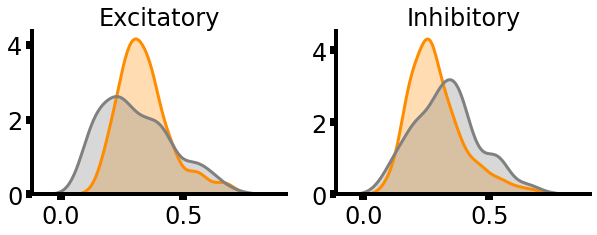

In [42]:
# define idxs
I_idxs = np.arange(1, 23, 2)
E_idxs = np.arange(0, 22, 2)

# extract e vs i similarities
E_obs_aggro = obs_aggro[E_idxs]
E_obs_non = obs_non[E_idxs]
I_obs_aggro = obs_aggro[I_idxs]
I_obs_non = obs_non[I_idxs]

distb1_E = E_obs_aggro.flatten()
distb1_E = distb1_E[~np.isnan(distb1_E)]
print(len(distb1_E))
distb2_E = E_obs_non.flatten()
distb2_E = distb2_E[~np.isnan(distb2_E)]
print(len(distb2_E))
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# plot exc distributions
sns.kdeplot(distb1_E, ax=ax[0], color='darkorange', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
sns.kdeplot(distb1_E, ax=ax[0], color='darkorange', lw=3)  # Line with higher alpha
sns.kdeplot(distb2_E, ax=ax[0], color='gray', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
sns.kdeplot(distb2_E, ax=ax[0], color='gray', lw=3) 
ax[0].set_ylabel('')
ax[0].tick_params(axis='y', labelsize=24)
ax[0].tick_params(axis='x', labelsize=24)
ax[0].set_title('Excitatory', fontsize=24)

# plot inhibitory distributions
distb1_I = I_obs_aggro.flatten()
distb1_I = distb1_I[~np.isnan(distb1_I)]
print(len(distb1_I))
distb2_I = I_obs_non.flatten()
distb2_I = distb2_I[~np.isnan(distb2_I)]
print(len(distb2_I))
sns.kdeplot(distb1_I, ax=ax[1], color='darkorange', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
sns.kdeplot(distb1_I, ax=ax[1], color='darkorange', lw=3)  # Line with higher alpha
sns.kdeplot(distb2_I, ax=ax[1], color='gray', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
sns.kdeplot(distb2_I, ax=ax[1], color='gray', lw=3)
ax[1].set_ylabel('')
ax[1].tick_params(axis='y', labelsize=24)
ax[1].tick_params(axis='x', labelsize=24)
ax[1].set_title('Inhibitory', fontsize=24)
sns.despine()

ks, p_value = ks_2samp(distb1_E, distb2_E)
print(f'KS test E: {p_value}')
print('KS statistic E: ', ks)
ks, p_value = ks_2samp(distb1_I, distb2_I)
print(f'KS test I: {p_value}')
print('KS statistic I: ', ks)
# plt.savefig('.\\figures\\TP_wholeE&I.svg', dpi=300)



### Doing same as above but for E-I

In [1126]:
def compute_EI(grid, n_clusters, n_animals=12):

	EI_grid = np.zeros((len(n_clusters), 11, grid.shape[2], n_animals))
	EI_grid[:] = np.nan

	for a in range(grid.shape[-1]):
		for i, idx in enumerate([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]): # E indices
			exc = grid[n_clusters, idx, :, a]
			inh = grid[n_clusters, idx+1, :, a]
			EI_grid[:, i, :, a] = (exc-inh) / (exc+inh+0.5)
			# EI_grid[:, i, :, a] = np.log(np.abs(exc)/np.abs(inh))

	return EI_grid

# For computing EI indices
total_sessions = 27
n_animals = 25
n_rois = 11

# Grab activity during aggression subclusters
n_clusters = np.arange(13)
EI_data = compute_EI(all_activity, n_clusters=np.array(n_clusters), n_animals=n_animals) 

# For saving
all_dists_EI = np.zeros((total_sessions, n_rois, n_animals, n_animals))
all_dists_EI[:] = np.nan
all_euclideans_EI = all_dists_EI.copy()
all_cosines_EI = all_dists_EI.copy()

for animal in np.arange(EI_data.shape[-1]):
	for roi in np.arange(n_rois):
		sample = EI_data[:, roi, :, animal]
		for second_animal in np.arange(EI_data.shape[-1]):
			if second_animal==animal:
				continue
			second_sample = EI_data[:, roi, :, second_animal]
			for session in np.arange(second_sample.shape[-1]):
				if np.all(np.isnan(second_sample[:, session])): # if all values are NaN,
					continue 
				all_euclideans_EI[session, roi, animal, second_animal] = np.linalg.norm(sample[:, session] - second_sample[:, session])
				all_dists_EI[session,roi,animal,second_animal] = dist_func(sample[:, session], second_sample[:, session])
				all_cosines_EI[session,roi,animal,second_animal] = np.clip(distance.cosine(sample[:, session], second_sample[:, session]), -1,1)

Mapping E-I similarities in hard fight

In [1127]:
dist_vector = all_cosines_EI.copy()

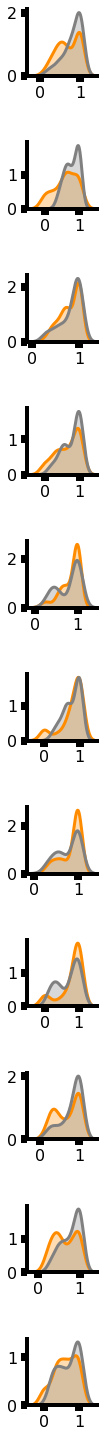

In [1128]:
# Assessing distributions during hard fight
t1 = -3
t2 = None
obs_non = np.median(dist_vector[t1:t2, :, np.arange(12, 19), 19:], axis=0)
obs_aggro = np.median(dist_vector[t1:t2, :, np.arange(12, 19), :12], axis=0)

# Inits
best_idxs = np.array([ 6,  8,  4,  2,  5, 10,  3,  7,  1,  0,  9])
indices_with_E = np.array([i for i, region in enumerate(region_ids) if "(E)" in region])
labels = [[region_ids[idx].replace(' (E)', '') for idx in indices_with_E][new_idx] for new_idx in best_idxs]

# Figs
fig, ax = plt.subplots(11, 1, figsize=(2, 20.5))
ax = ax.flatten()

p_values = []
for r, region in enumerate(best_idxs):

	distb1 = obs_aggro[region].flatten()
	distb1 = distb1[~np.isnan(distb1)]
	distb2 = obs_non[region].flatten()
	distb2 = distb2[~np.isnan(distb2)]
	ax[r].tick_params(axis='y', labelsize=16)
	# ax[r].set_title(labels[r], color='black')

	# Plot KDEs
	sns.kdeplot(distb1, ax=ax[r], color='darkorange', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
	sns.kdeplot(distb1, ax=ax[r], color='darkorange', lw=3)  # Line with higher alpha
	sns.kdeplot(distb2, ax=ax[r], color='gray', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
	sns.kdeplot(distb2, ax=ax[r], color='gray', lw=3) 
	ax[r].set_ylabel('')
	sns.despine()

	ks_statistic, p_value = ks_2samp(distb1, distb2)
	ax[r].tick_params(axis='x', labelsize=16)
	p_values.append(p_value)

# Remove empty axes
plt.tight_layout()
plt.subplots_adjust(hspace=1)
# plt.savefig('.\\figures\\obs_non_aggro_EI_distributions_HF.svg', dpi=300)

In [1129]:
# run multiple comparisons correction

from statsmodels.stats.multitest import multipletests
reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_tsbh')
for r, region in enumerate(labels):
	print(region, pvals_corrected[r])

VMH 0.12649477640331724
PMv 0.2027447740890786
AH 0.4706811283964943
POA 0.33483350424788766
MeA 0.33483350424788766
PA 0.5719692566637529
BNST 0.542247108133925
PAG 0.33483350424788766
vLS 0.21732662343642029
PrL 0.12649477640331724
LHb 0.44242127126752473


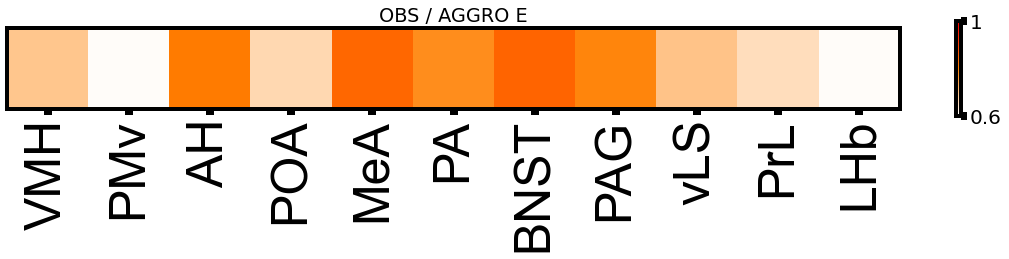

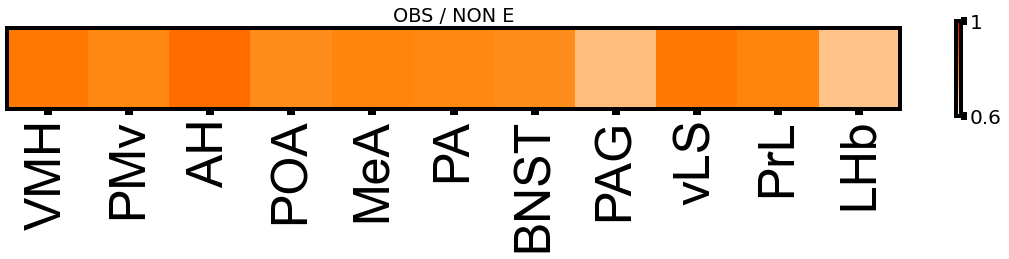

In [1130]:
np.set_printoptions(precision=4, suppress=True)
n = len(region_ids)
new_idx = (np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18])/2).astype(int)
# define the colormap
colors = [(1, 1, 1), (1, 0.5, 0), (1, 0, 0)]  # White to orange to red
n_bins = 100  # Number of bins in the colormap
cmap_name = 'custom_autumn_r'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
cmap = custom_cmap.copy()

### OBS-AGG E 
weights2map = obs_aggro.copy()
weights2map = np.nanmean(weights2map, axis=-1)
weights = np.nanmean(weights2map, axis=1)
weights_sorted = weights[new_idx]
all_labels = [[region_ids[idx].replace(' (E)', '') for idx in indices_with_E][new_idx] for new_idx in best_idxs]
vmin=0.6
vmax = 1
norm = Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(20, 5))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin, 12, vmax])
cbar.set_ticklabels([vmin, 12, vmax], fontsize=20)
ax.set_xticks(np.arange(len(new_idx)), all_labels, rotation=90, fontfamily='Arial', fontsize=50);
ax.set_yticks([])
ax.set_title('OBS / AGGRO E')
plt.savefig('.\\figures\\obs_aggro_distributions_means_EI_HF.svg', dpi=300)

### OBS-NON E 
weights2map = obs_non.copy()
weights2map = np.nanmean(weights2map, axis=-1)
weights = np.nanmean(weights2map, axis=-1)
weights_sorted = weights[new_idx]
fig, ax = plt.subplots(figsize=(20, 5))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin, 12, vmax])
cbar.set_ticklabels([vmin, 12, vmax], fontsize=20)
ax.set_xticks(np.arange(len(new_idx)), all_labels, rotation=90, fontfamily='Arial', fontsize=50);
ax.set_yticks([])
ax.set_title('OBS / NON E')
plt.savefig('.\\figures\\obs_non_distributions_means_EI_HF.svg', dpi=300)


In [1131]:
p_values = []  # List to collect all p-values

# Assuming your vectors are named vector1, vector2, and vector3

for r in np.arange(11):
	agg_roi_activity = obs_aggro[r, :][np.isnan(obs_aggro[r, :])==False]
	non_roi_activity = obs_non[r, :][np.isnan(obs_non[r, :])==False]

	# Test for normality
	_, p_agg = stats.shapiro(agg_roi_activity)
	_, p_non = stats.shapiro(non_roi_activity)

	# If the p-value is greater than 0.05, the data is normally distributed
	if p_agg > 0.05 and p_non > 0.05:
		# Perform t-tests
		_, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
	else:
		# Perform Wilcoxon rank-sum tests
		_, p_agg_non = stats.mannwhitneyu(agg_roi_activity, non_roi_activity)
	p_values.append(p_agg_non)  # Collect Wilcoxon p-values
	
# Apply FDR correction
p_adjusted = multipletests(p_values, method='fdr_tsbh')[1]
p_adjusted = np.array(p_adjusted)[new_idx]

for i, roi in enumerate(all_labels):
	print(f'{roi}: obs-agg vs obs-non p-value = {p_adjusted[i]}')

VMH: obs-agg vs obs-non p-value = 0.07226100418623711
PMv: obs-agg vs obs-non p-value = 0.02906672381398359
AH: obs-agg vs obs-non p-value = 0.5063609390254288
POA: obs-agg vs obs-non p-value = 0.10940791850409676
MeA: obs-agg vs obs-non p-value = 0.5063609390254288
PA: obs-agg vs obs-non p-value = 0.5063609390254288
BNST: obs-agg vs obs-non p-value = 0.1923334936710647
PAG: obs-agg vs obs-non p-value = 0.10940791850409676
vLS: obs-agg vs obs-non p-value = 0.10164815558761511
PrL: obs-agg vs obs-non p-value = 0.02906672381398359
LHb: obs-agg vs obs-non p-value = 0.18312367367341234


Mapping E-I similarities in the training period

In [ ]:
# Grab activity during aggression subclusters
n_clusters = np.arange(10)
EI_data = compute_EI(all_activity, n_clusters=np.array(n_clusters), n_animals=n_animals) 

# For saving
all_dists_EI = np.zeros((total_sessions, n_rois, n_animals, n_animals))
all_dists_EI[:] = np.nan
all_euclideans_EI = all_dists_EI.copy()
all_cosines_EI = all_dists_EI.copy()

for animal in np.arange(EI_data.shape[-1]):
	for roi in np.arange(n_rois):
		sample = EI_data[:, roi, :, animal]
		for second_animal in np.arange(EI_data.shape[-1]):
			if second_animal==animal:
				continue
			second_sample = EI_data[:, roi, :, second_animal]
			for session in np.arange(second_sample.shape[-1]):
				if np.all(np.isnan(second_sample[:, session])): # if all values are NaN,
					continue 
				all_euclideans_EI[session, roi, animal, second_animal] = np.linalg.norm(sample[:, session] - second_sample[:, session])
				all_dists_EI[session,roi,animal,second_animal] = dist_func(sample[:, session], second_sample[:, session])
				all_cosines_EI[session,roi,animal,second_animal] = np.clip(distance.cosine(sample[:, session], second_sample[:, session]), -1,1)

In [ ]:
dist_vector = all_cosines_EI.copy()

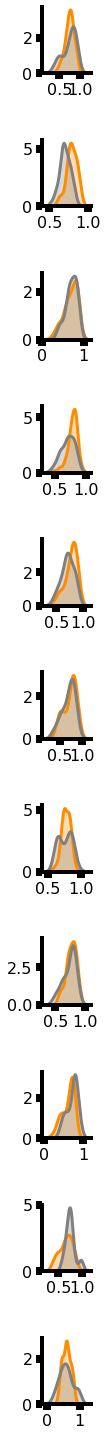

In [1132]:
# Assessing distributions during training period
t1 = 0
t2 = -3
obs_non = np.mean(dist_vector[t1:t2, :, np.arange(12, 19), 19:], axis=0)
obs_aggro = np.mean(dist_vector[t1:t2, :, np.arange(12, 19), :12], axis=0)

# Inits
best_idxs = np.array([ 6,  8,  4,  2,  5, 10,  3,  7,  1,  0,  9])
indices_with_E = np.array([i for i, region in enumerate(region_ids) if "(E)" in region])
labels = [[region_ids[idx].replace(' (E)', '') for idx in indices_with_E][new_idx] for new_idx in best_idxs]

# Figs
fig, ax = plt.subplots(11, 1, figsize=(2, 20.5))
ax = ax.flatten()

p_values = []
for r, region in enumerate(best_idxs):

	distb1 = obs_aggro[region].flatten()
	distb1 = distb1[~np.isnan(distb1)]
	distb2 = obs_non[region].flatten()
	distb2 = distb2[~np.isnan(distb2)]
	ax[r].tick_params(axis='y', labelsize=16)
	# ax[r].set_title(labels[r], color='black')

	# Plot KDEs
	sns.kdeplot(distb1, ax=ax[r], color='darkorange', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
	sns.kdeplot(distb1, ax=ax[r], color='darkorange', lw=3)  # Line with higher alpha
	sns.kdeplot(distb2, ax=ax[r], color='gray', multiple='layer', fill=True, alpha=0.3, lw=0)  # Fill with lower alpha
	sns.kdeplot(distb2, ax=ax[r], color='gray', lw=3) 
	ax[r].set_ylabel('')
	sns.despine()
	ks_statistic, p_value = ks_2samp(distb1, distb2)
	ax[r].tick_params(axis='x', labelsize=16)
	p_values.append(p_value)

plt.tight_layout()
plt.subplots_adjust(hspace=1)
# plt.savefig('.\\figures\\obs_non_aggro_EI_distributions_TP.svg', dpi=300)

In [1133]:
# run multiple comparisons correction

from statsmodels.stats.multitest import multipletests
reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_tsbh')
for r, region in enumerate(labels):
	print(region, pvals_corrected[r])

VMH 0.07737010204258567
PMv 2.9566807024372643e-05
AH 0.4002960236912626
POA 0.0002751360753183718
MeA 0.007149997295707533
PA 0.2905454987774957
BNST 0.013936388623399984
PAG 0.21910255872005172
vLS 0.0012942080326418248
PrL 0.0012942080326418248
LHb 0.2521670227789465


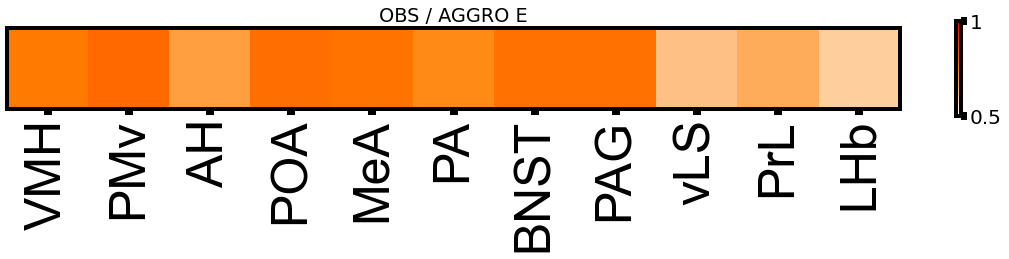

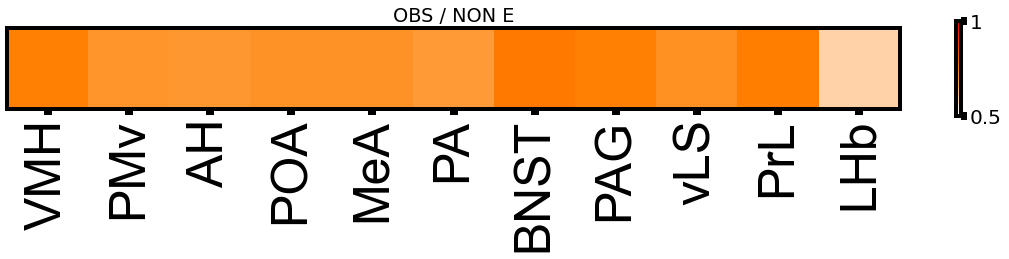

In [1134]:
np.set_printoptions(precision=4, suppress=True)
n = len(region_ids)
new_idx = (np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18])/2).astype(int)
# define the colormap
colors = [(1, 1, 1), (1, 0.5, 0), (1, 0, 0)]  # White to orange to red
n_bins = 100  # Number of bins in the colormap
cmap_name = 'custom_autumn_r'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
cmap = custom_cmap.copy()

### OBS-AGG E 
weights2map = obs_aggro.copy()
weights2map = np.nanmean(weights2map, axis=-1)
weights = np.nanmean(weights2map, axis=1)
weights_sorted = weights[new_idx]
all_labels = [[region_ids[idx].replace(' (E)', '') for idx in indices_with_E][new_idx] for new_idx in best_idxs]
vmin=0.5
vmax = 1
norm = Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(20, 5))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin, 12, vmax])
cbar.set_ticklabels([vmin, 12, vmax], fontsize=20)
ax.set_xticks(np.arange(len(new_idx)), all_labels, rotation=90, fontfamily='Arial', fontsize=50);
ax.set_yticks([])
ax.set_title('OBS / AGGRO E')
plt.savefig('.\\figures\\obs_aggro_distributions_means_EI_TP.svg', dpi=300)

### OBS-NON E 
weights2map = obs_non.copy()
weights2map = np.nanmean(weights2map, axis=-1)
weights = np.nanmean(weights2map, axis=-1)
weights_sorted = weights[new_idx]
fig, ax = plt.subplots(figsize=(20, 5))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin, 12, vmax])
cbar.set_ticklabels([vmin, 12, vmax], fontsize=20)
ax.set_xticks(np.arange(len(new_idx)), all_labels, rotation=90, fontfamily='Arial', fontsize=50);
ax.set_yticks([])
ax.set_title('OBS / NON E')
plt.savefig('.\\figures\\obs_non_distributions_means_EI_TP.svg', dpi=300)


In [1135]:
p_values = []  # List to collect all p-values

obs_aggro_arranged = np.nanmean(obs_aggro, axis=-1)
obs_non_arranged = np.nanmean(obs_non, axis=-1)

for r in np.arange(11):
	agg_roi_activity = obs_aggro_arranged[r, :][np.isnan(obs_aggro_arranged[r, :])==False]
	non_roi_activity = obs_non_arranged[r, :][np.isnan(obs_non_arranged[r, :])==False]

	# Test for normality
	_, p_agg = stats.shapiro(agg_roi_activity)
	_, p_non = stats.shapiro(non_roi_activity)

	# If the p-value is greater than 0.05, the data is normally distributed
	if p_agg > 0.05 and p_non > 0.05:
		# Perform t-tests
		_, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
	else:
		# Perform Wilcoxon rank-sum tests
		_, p_agg_non = stats.mannwhitneyu(agg_roi_activity, non_roi_activity)
	p_values.append(p_agg_non)  # Collect Wilcoxon p-values
	
# Apply FDR correction
p_adjusted = multipletests(p_values, method='fdr_tsbh')[1]
p_adjusted = np.array(p_adjusted)[new_idx]

for i, roi in enumerate(all_labels):
	print(f'{roi}: obs-agg vs obs-non p-value = {p_adjusted[i]}')

VMH: obs-agg vs obs-non p-value = 0.6140099748151996
PMv: obs-agg vs obs-non p-value = 0.02885762223938386
AH: obs-agg vs obs-non p-value = 0.6140099748151996
POA: obs-agg vs obs-non p-value = 0.06627068129665392
MeA: obs-agg vs obs-non p-value = 0.08873522914272519
PA: obs-agg vs obs-non p-value = 0.5884207028686267
BNST: obs-agg vs obs-non p-value = 0.6140099748151996
PAG: obs-agg vs obs-non p-value = 0.5403880041506003
vLS: obs-agg vs obs-non p-value = 0.16472699035577182
PrL: obs-agg vs obs-non p-value = 0.02885762223938386
LHb: obs-agg vs obs-non p-value = 0.6140099748151996


Social vs nonsocial preferences?

In [263]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

def run_group_comparison(data2plot):

	agg_roi_activity = data2plot[0][np.isnan(data2plot[0])==False]
	obs_roi_activity = data2plot[1][np.isnan(data2plot[1])==False]
	non_roi_activity = data2plot[2][np.isnan(data2plot[2])==False]

	# Add the data to the DataFrame
	df = pd.DataFrame({
		'Activity': np.concatenate([agg_roi_activity, obs_roi_activity, non_roi_activity]),
		'Group': np.concatenate([['agg'] * len(agg_roi_activity), ['obs'] * len(obs_roi_activity), ['non'] * len(non_roi_activity)]),
	})

	# Test for normality
	_, p_agg = stats.shapiro(agg_roi_activity)
	_, p_obs = stats.shapiro(obs_roi_activity)
	_, p_non = stats.shapiro(non_roi_activity)
	
	if p_agg > 0.05 and p_obs > 0.05 and p_non > 0.05:
		# Perform the one-way ANOVA
		model = sm.OLS.from_formula('Activity ~ C(Group)', data=df).fit()
		anova_table = sm.stats.anova_lm(model, typ=2)
		print("F = %f, p = %f" % (anova_table['F'][0], anova_table['PR(>F)'][0]))
		if anova_table['PR(>F)'][0] <= 0.1:
			t1, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
			t2, p_obs_non = stats.ttest_ind(obs_roi_activity, non_roi_activity)
			t3, p_agg_obs = stats.ttest_ind(agg_roi_activity, obs_roi_activity)
			multiple_tests = multipletests([p_agg_non, p_agg_obs, p_obs_non], method='fdr_tsbh')
			print('AGG vs NON; t = %f, p = %f' % (t1, multiple_tests[1][0]))
			print('AGG vs OBS; t = %f, p = %f' % (t3, multiple_tests[1][1]))
			print('OBS vs NON; t = %f, p = %f' % (t2, multiple_tests[1][2]))
	else:
		# Perform Kruskal-Wallis H-test
		kruskal_result = stats.kruskal(agg_roi_activity, obs_roi_activity, non_roi_activity)
		print("H = %f, p = %f" % (kruskal_result.statistic, kruskal_result.pvalue))
		if kruskal_result.pvalue <= 0.1:
			t1, p_agg_non = stats.mannwhitneyu(agg_roi_activity, non_roi_activity)
			t2, p_obs_non = stats.mannwhitneyu(obs_roi_activity, non_roi_activity)
			t3, p_agg_obs = stats.mannwhitneyu(agg_roi_activity, obs_roi_activity)
			multiple_tests = multipletests([p_agg_non, p_agg_obs, p_obs_non], method='fdr_tsbh')
			print('AGG vs NON; U = %f, p = %f' % (t1, multiple_tests[1][0]))
			print('AGG vs OBS; U = %f, p = %f' % (t3, multiple_tests[1][1]))
			print('OBS vs NON; U = %f, p = %f' % (t2, multiple_tests[1][2]))
	print('###')

def run_comparisons_to_0(data2plot):

    agg_roi_activity = data2plot[0][np.isnan(data2plot[0]) == False]
    obs_roi_activity = data2plot[1][np.isnan(data2plot[1]) == False]

    # Test for normality
    _, p_agg = stats.shapiro(agg_roi_activity)
    _, p_obs = stats.shapiro(obs_roi_activity)

    # Test whether agg_roi_activity is significantly different from 0
    if p_obs > 0.05:
        # Perform one-sample t-test
        t_agg, p_agg_zero = stats.ttest_1samp(agg_roi_activity, 0)
    else:
        # Perform Wilcoxon signed-rank test
        t_agg, p_agg_zero = stats.wilcoxon(agg_roi_activity - 0)

    # Test whether non_roi_activity is significantly different from 0
    if p_obs > 0.05:
        # Perform one-sample t-test
        t_obs, p_obs_zero = stats.ttest_1samp(obs_roi_activity, 0)
    else:
        # Perform Wilcoxon signed-rank test
        t_obs, p_obs_zero = stats.wilcoxon(obs_roi_activity - 0)

    return [p_agg_zero, p_obs_zero]

Hard fight: social vs nonsocial

In [302]:
def compute_activity(grid, n_clusters, n_animals=12):

	activity_grid = np.zeros((len(n_clusters), len(region_ids), grid.shape[2], n_animals))
	activity_grid[:] = np.nan

	for a in range(grid.shape[-1]):
		for i, idx in enumerate(region_ids): # E indices
			activity = grid[n_clusters, i, :, a] # if clusters are selected monotonically
			activity_grid[:, i, :, a] = activity

	return activity_grid

mean_func = np.nanmean

# For computing EI indices
n_clusters = np.arange(13)
total_sessions = 27
n_rois = len(region_ids)

# ALL
n_animals = 25
up_clusters = np.arange(8) # <---
up_clusters = np.array([0, 1, 2, 3, 7]) # <---
down_clusters = np.array([10, 11, 12])
activity_data_up = np.zeros((len(up_clusters), n_rois, 27, n_animals)) # modify the animals here
activity_data_up = compute_activity(all_activity, n_clusters=up_clusters, n_animals=n_animals) 
activity_data_down = np.zeros((len(down_clusters), n_rois, 27, n_animals)) # modify the animals here
activity_data_down = compute_activity(all_activity, n_clusters=down_clusters, n_animals=n_animals) 


# For saving
all_dists_up = np.zeros((total_sessions, n_rois, n_animals))
all_dists_up[:] = np.nan

for animal in np.arange(activity_data_up.shape[-1]):
	for roi in np.arange(n_rois):
		sample = activity_data_up[:, roi, :, animal]
		for i in enumerate(np.arange(sample.shape[1])):
			dist = mean_func(activity_data_up[:, roi, i, animal])
			if dist==np.inf:
				dist = np.nan
			all_dists_up[i,roi,animal] = dist

# For saving
all_dists_down = np.zeros((total_sessions, n_rois, n_animals))
all_dists_down[:] = np.nan

for animal in np.arange(activity_data_down.shape[-1]):
	for roi in np.arange(n_rois):
		sample = activity_data_down[:, roi, :, animal]
		for i in enumerate(np.arange(sample.shape[1])):
			dist = mean_func(activity_data_down[:, roi, i, animal])
			if dist==np.inf:
				dist = np.nan
			all_dists_down[i,roi,animal] = dist

all_dists = np.log(all_dists_up / all_dists_down)
all_dists[all_dists==np.inf] = np.nan

VMHvl
F = 0.999528, p = 0.384161
###
PMv
F = 1.386185, p = 0.275472
###
AH
H = 1.840994, p = 0.398321
###
POA
F = 1.279489, p = 0.298992
###
MeA
F = 0.194388, p = 0.824803
###
PA
F = 3.948172, p = 0.036819
AGG vs NON; t = 3.755219, p = 0.004807
AGG vs OBS; t = 0.125027, p = 0.601520
OBS vs NON; t = 1.979652, p = 0.073313
###
BNST
F = 2.115318, p = 0.146775
###
PAG
F = 0.160675, p = 0.852777
###
vLS
F = 1.841521, p = 0.182196
###
PrL
F = 0.915547, p = 0.415692
###
LHb
H = 0.102195, p = 0.950186
###
VMHvl
H = 1.006813, p = 0.604468
###
PMv
F = 0.281985, p = 0.757556
###
AH
H = 2.556522, p = 0.278521
###
POA
H = 2.596364, p = 0.273028
###
MeA
F = 3.029559, p = 0.069825
AGG vs NON; t = -2.276500, p = 0.113715
AGG vs OBS; t = -0.963375, p = 0.349695
OBS vs NON; t = -1.681661, p = 0.181159
###
PA
F = 0.468736, p = 0.632839
###
BNST
H = 3.921429, p = 0.140758
###
PAG
F = 1.308811, p = 0.294649
###
vLS
F = 2.128823, p = 0.142835
###
PrL
F = 1.380661, p = 0.273314
###
LHb
F = 0.759349, p = 0.48

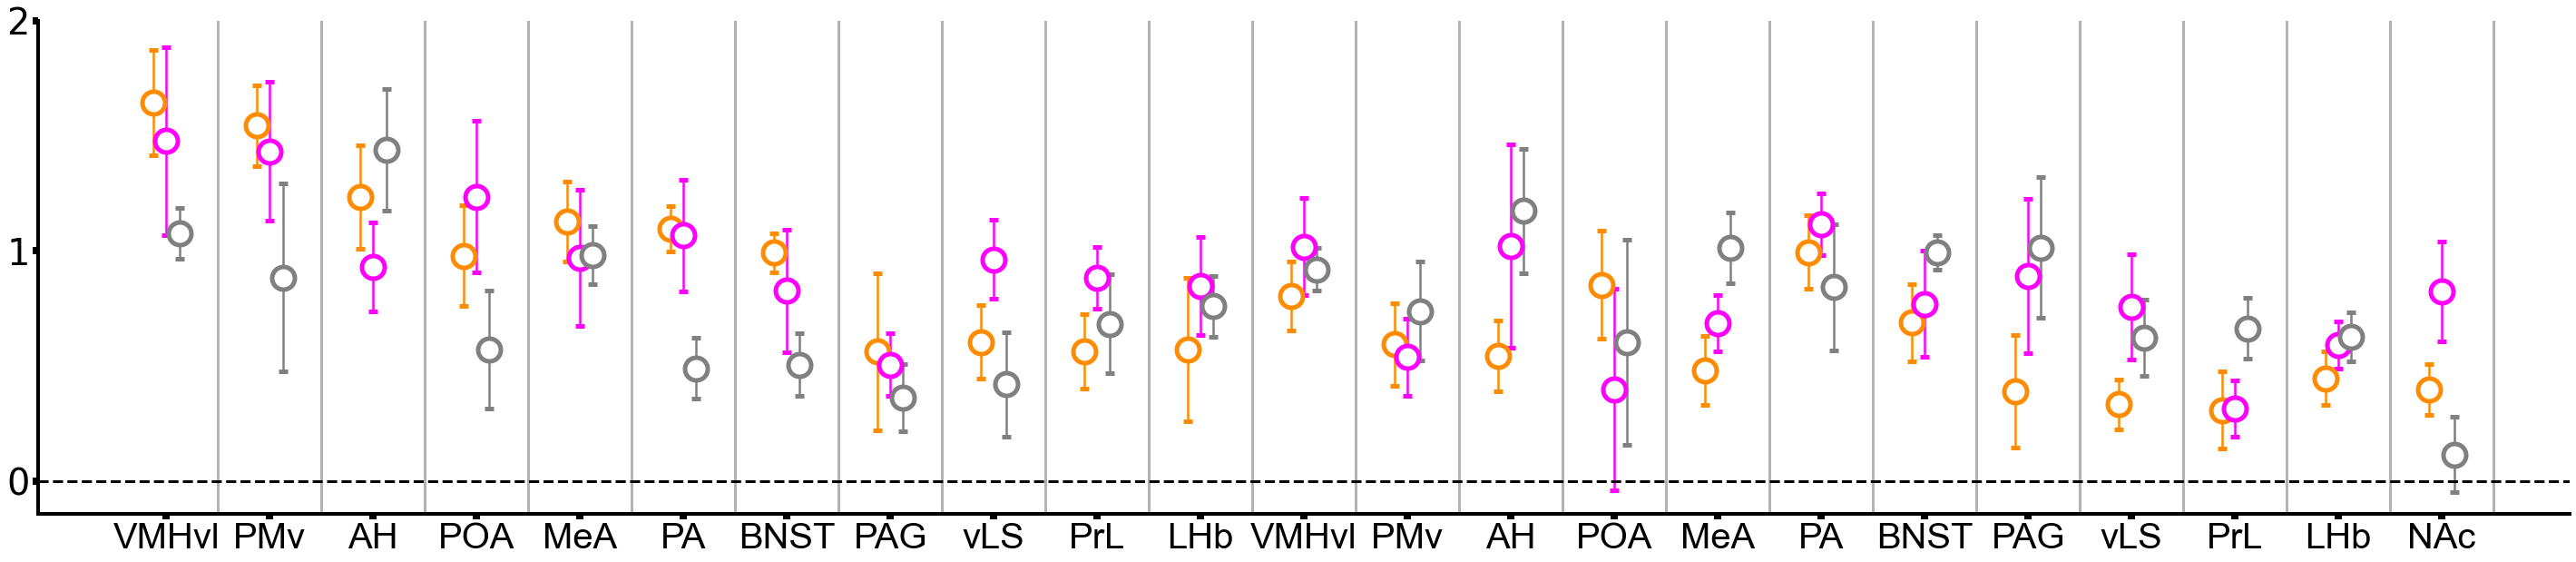

In [305]:
from scipy.stats import sem
fig, ax = plt.subplots(figsize=(50, 10))
new_labels = np.array(['PrL', 'PrL', 'vLS', 'vLS', 'POA', 'POA', 'BNST', 'BNST', 'AH', 'AH', 'MeA', 'MeA', 
			  'VMHvl', 'VMHvl', 'PAG', 'PAG', 'PMv', 'PMv', 'LHb', 'LHb', 'PA', 'PA', 'NAc'])
remixed = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19, 22])
indices = []

# Initialize x position counter
x_counter = 0

for r, (roi, idx) in enumerate(zip(new_labels[remixed], remixed)):
    # Define the x position for all points
    values = np.nanmedian(all_dists[-3:, idx, :], axis=0)
    print(roi)
    run_group_comparison([values[:12], values[12:19], values[19:]])
    
    x_pos = np.array([0, 1, 2]) + x_counter
    x_counter += 8
    indices.append(x_counter) # Increment x position counter
    
    points = [np.nanmean(values[:12]), np.nanmean(values[12:19]), np.nanmean(values[19:])]
    sems = [sem(np.array(values[:12]), nan_policy='omit'), sem(np.array(values[12:19]), nan_policy='omit'), sem(np.array(values[19:]), nan_policy='omit')]
    colors = ['darkorange', 'magenta', 'gray']
    
    # Plot each point with its error bar
    for i in range(len(points)):
        ax.errorbar(x_pos[i], points[i], yerr=sems[i], fmt='o', markersize=25, capsize=5, capthick=5, 
                    markerfacecolor='white', markeredgewidth=5, color=colors[i])

plt.xticks(np.array(indices)-7, new_labels[remixed], rotation=0, fontfamily='Arial', fontsize=40)
plt.yticks([0, 1, 2], fontsize=40)
plt.axhline(0, color='black', lw=3, linestyle='--')
for i in indices:
    plt.axvline(i-3, color='black', lw=3, alpha=0.3)
sns.despine()
# plt.savefig('.\\figures\\social_vs_nonsocial_HF.svg', dpi=300)
plt.savefig('.\\figures\\aggrp_vs_nonsocial_HF.svg', dpi=300)

Training period: aggression vs nonsocial

In [299]:
def compute_activity(grid, n_clusters, n_animals=12):

	activity_grid = np.zeros((len(n_clusters), len(region_ids), grid.shape[2], n_animals))
	activity_grid[:] = np.nan

	for a in range(grid.shape[-1]):
		for i, idx in enumerate(region_ids): # E indices
			activity = grid[n_clusters, i, :, a] # if clusters are selected monotonically
			activity_grid[:, i, :, a] = activity

	return activity_grid

mean_func = np.nanmean

# For computing EI indices
n_clusters = np.arange(13)
total_sessions = 27
n_rois = len(region_ids)

# ALL
n_animals = 25
up_clusters = np.array([0,1,2,3,7]) # <---
down_clusters = np.array([10, 11, 12])
activity_data_up = np.zeros((len(up_clusters), n_rois, 27, n_animals)) # modify the animals here
activity_data_up = compute_activity(all_activity, n_clusters=up_clusters, n_animals=n_animals) 
activity_data_down = np.zeros((len(down_clusters), n_rois, 27, n_animals)) # modify the animals here
activity_data_down = compute_activity(all_activity, n_clusters=down_clusters, n_animals=n_animals) 


# For saving
all_dists_up = np.zeros((total_sessions, n_rois, n_animals))
all_dists_up[:] = np.nan

for animal in np.arange(activity_data_up.shape[-1]):
	for roi in np.arange(n_rois):
		sample = activity_data_up[:, roi, :, animal]
		for i in enumerate(np.arange(sample.shape[1])):
			dist = mean_func(activity_data_up[:, roi, i, animal])
			if dist==np.inf:
				dist = np.nan
			all_dists_up[i,roi,animal] = dist

# For saving
all_dists_down = np.zeros((total_sessions, n_rois, n_animals))
all_dists_down[:] = np.nan

for animal in np.arange(activity_data_down.shape[-1]):
	for roi in np.arange(n_rois):
		sample = activity_data_down[:, roi, :, animal]
		for i in enumerate(np.arange(sample.shape[1])):
			dist = mean_func(activity_data_down[:, roi, i, animal])
			if dist==np.inf:
				dist = np.nan
			all_dists_down[i,roi,animal] = dist

all_dists = np.log(all_dists_up / all_dists_down)
all_dists[all_dists==np.inf] = np.nan

In [300]:
from scipy.stats import sem
new_labels = np.array(['PrL', 'PrL', 'vLS', 'vLS', 'POA', 'POA', 'BNST', 'BNST', 'AH', 'AH', 'MeA', 'MeA', 
			  'VMHvl', 'VMHvl', 'lPAG', 'lPAG', 'PMv', 'PMv', 'LHb', 'LHb', 'PA', 'PA', 'NAc'])
remixed = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19, 22])
indices = []

# Initialize x position counter
x_counter = 0
p_values = []
for r, (roi, idx) in enumerate(zip(new_labels[remixed], remixed)):
    # Define the x position for all points
    values = np.nanmean(all_dists[:6, idx, :], axis=0)
    exp_ratio = values[:12]
    obs_ratio = values[12:19]
    p1, p2 = run_comparisons_to_0([values[:12], values[12:19]])
    p_values.extend([p1, p2])

In [301]:
# run multiple comparisons correction
reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_tsbh')
p_values_AGG = pvals_corrected[::2]
p_values_OBS = pvals_corrected[1::2]

for i, roi in enumerate(new_labels[remixed]):
    print(f'{roi}: p-value AGG = {p_values_AGG[i]}, p-value OBS = {p_values_OBS[i]}')



VMHvl: p-value AGG = 9.643059017458931e-07, p-value OBS = 0.013966813554243649
PMv: p-value AGG = 5.997555180925402e-05, p-value OBS = 0.010442683434148767
AH: p-value AGG = 0.00887784090909091, p-value OBS = 0.03077762601649175
POA: p-value AGG = 0.001012601835784175, p-value OBS = 0.028925626255567563
MeA: p-value AGG = 0.00021194497889919485, p-value OBS = 0.4013611757363762
PA: p-value AGG = 0.00390625, p-value OBS = 0.4076086956521739
BNST: p-value AGG = 0.0002484199959565692, p-value OBS = 0.002107582549762805
lPAG: p-value AGG = 0.028925626255567563, p-value OBS = 0.12874291607360952
vLS: p-value AGG = 8.28503671868946e-05, p-value OBS = 0.03077762601649175
PrL: p-value AGG = 0.002107582549762805, p-value OBS = 0.03077762601649175
LHb: p-value AGG = 0.23766055711522546, p-value OBS = 0.03459083367114544
VMHvl: p-value AGG = 2.7658700775974615e-05, p-value OBS = 0.009502725319314592
PMv: p-value AGG = 0.0002678402191799033, p-value OBS = 0.03459083367114544
AH: p-value AGG = 0.00

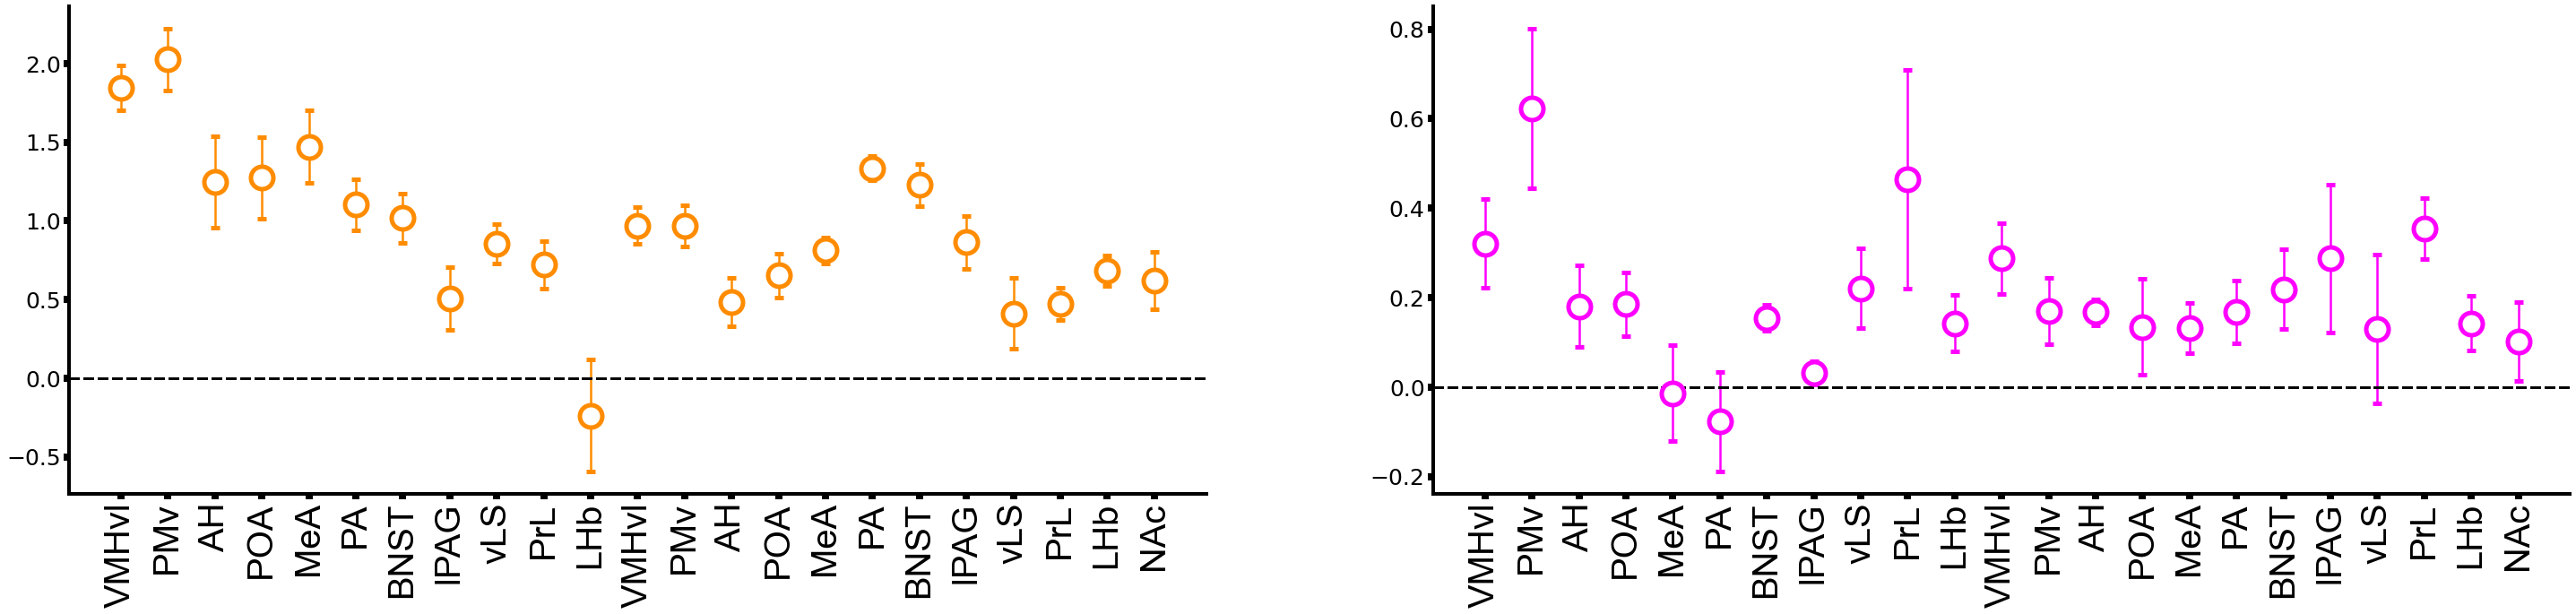

In [295]:
fig, ax = plt.subplots(1, 2, figsize=(50, 10))
for r, (roi, idx) in enumerate(zip(new_labels[remixed], remixed)):
    values = np.nanmean(all_dists[:6, idx, :], axis=0)
    
	# EXP
    ratio = values[:12]
    meanz = np.nanmean(ratio)
    semz = sem(ratio, nan_policy='omit')
    ax[0].errorbar(r, meanz, yerr=semz, fmt='o', markersize=25, capsize=5, capthick=5, 
                    markerfacecolor='white', markeredgewidth=5, color='darkorange')
    ax[0].axhline(0, color='black', lw=3, linestyle='--')
    ax[0].set_xticks(np.arange(len(new_labels)), new_labels[remixed], rotation=90, fontfamily='Arial', fontsize=40)
    
	# OBS 
    ratio = values[12:19]
    meanz = np.nanmean(ratio)
    semz = sem(ratio, nan_policy='omit')
    ax[1].errorbar(r, meanz, yerr=semz, fmt='o', markersize=25, capsize=5, capthick=5, 
					markerfacecolor='white', markeredgewidth=5, color='magenta')
    ax[1].axhline(0, color='black', lw=3, linestyle='--')
    ax[1].set_xticks(np.arange(len(new_labels)), new_labels[remixed], rotation=90, fontfamily='Arial', fontsize=40)
    sns.despine()
    
plt.savefig('.\\figures\\social_vs_nonsocial_TP.svg', dpi=300)
	
